In [222]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import re
from os import path
from glob import glob
from tqdm import tqdm
import numpy as np
from matplotlib import cm
from pprint import pprint


In [223]:
StatisticsColumns = [
    'ReachedKnowledgeStep',
    #'AlmostReachedKnowledgeStep',
    'Matched_HorizontalPiece', 'Matched_VerticalPiece', 'Matched_CrossPiece', 'Matched_RocketPiece', 'Matched_BombPiece', 'Matched_RainbowPiece']

In [224]:
original_df = pd.read_csv('original_df.csv')
print(set(original_df['objective']))

{'score', '-', 'knowledge'}


C:\Users\GIST\.conda\envs\mlagents\lib\site-packages\IPython\core\interactiveshell.py:3553: DtypeWarning: Columns (29,31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [225]:
original_df.head()


,Unnamed: 0,EpisodeCount,StepCount,Time,InstanceUUID,SettleCount,ChangedCount,MeanComparisonCount,StdComparisonCount,ReachedKnowledgeStep,...,Target_BombPiece,Target_RainbowPiece,method,player,simpleEffect,objective,simulation,almostRatio,playerDepth,Sum_Matched
0,0,1,200,2023-05-26 07:51:49.845,b1f56767,0,254,1.032544,0.786839,130,...,2,3,mcts,0,1,knowledge,1000,1.0,1,546
1,1,2,200,2023-05-26 07:55:40.408,b1f56767,0,267,1.086053,0.741027,-1,...,2,3,mcts,0,1,knowledge,1000,1.0,1,474
2,2,3,200,2023-05-26 08:00:36.138,b1f56767,0,283,1.094556,0.726904,199,...,2,3,mcts,0,1,knowledge,1000,1.0,1,420
3,3,4,200,2023-05-26 08:05:35.639,b1f56767,0,261,1.078550,0.778417,25,...,2,3,mcts,0,1,knowledge,1000,1.0,1,372
4,4,5,200,2023-05-26 08:10:08.346,b1f56767,0,258,1.011461,0.776734,33,...,2,3,mcts,0,1,knowledge,1000,1.0,1,438


In [226]:
original_df.columns.values.tolist()

['Unnamed: 0',
 'EpisodeCount',
 'StepCount',
 'Time',
 'InstanceUUID',
 'SettleCount',
 'ChangedCount',
 'MeanComparisonCount',
 'StdComparisonCount',
 'ReachedKnowledgeStep',
 'Q1ReachedKnowledgeStep',
 'Q2ReachedKnowledgeStep',
 'Q3ReachedKnowledgeStep',
 'Matched_HorizontalPiece',
 'Matched_VerticalPiece',
 'Matched_CrossPiece',
 'Matched_RocketPiece',
 'Matched_BombPiece',
 'Matched_RainbowPiece',
 'Target_HorizontalPiece',
 'Target_VerticalPiece',
 'Target_CrossPiece',
 'Target_RocketPiece',
 'Target_BombPiece',
 'Target_RainbowPiece',
 'method',
 'player',
 'simpleEffect',
 'objective',
 'simulation',
 'almostRatio',
 'playerDepth',
 'Sum_Matched']

In [227]:
original_df['ReachedKnowledgeStep'] = original_df['ReachedKnowledgeStep'].replace(-1, 200)
original_df['Q1ReachedKnowledgeStep'] = original_df['Q1ReachedKnowledgeStep'].replace(-1, 200)
original_df['Q2ReachedKnowledgeStep'] = original_df['Q2ReachedKnowledgeStep'].replace(-1, 200)
original_df['Q3ReachedKnowledgeStep'] = original_df['Q3ReachedKnowledgeStep'].replace(-1, 200)

original_df.rename(columns={
                            'ReachedKnowledgeStep': '100%',
                            'Q1ReachedKnowledgeStep': '25%',
                            'Q2ReachedKnowledgeStep': '50%',
                            'Q3ReachedKnowledgeStep': '75%'
                            }, inplace=True)


for i in range(5):
    original_df['playerDepth'] = original_df['playerDepth'].replace(str(i), i)
for i in range(100, 1100, 100):
    original_df['simulation'] = original_df['simulation'].replace(str(i), i)

In [228]:
# pd.set_option('display.max_rows', None)


match_result = original_df.copy()
match_result = match_result[~match_result['almostRatio'].isin(['0.75'])]
match_result = match_result[~match_result['playerDepth'].isin([2, 3])]
match_result = match_result[~match_result['simulation'].isin([100, 400])]

def remove_outliers(column):
    # Calculate the z-score for the column
    z_scores = (column - column.mean()) / column.std()

    # Define the threshold for outliers (e.g., z-score > 3 or z-score < -3)
    threshold = 3
    # Return the column without the outliers
    column[~(z_scores > -threshold)] = -9999
    column[~(z_scores < threshold)] = -9999

    return column


columns_to_remove_outliers = ['25%',
                              '50%',
                              '75%',
                              '100%',
                            ]

for column in columns_to_remove_outliers:
    match_result[column] = match_result.groupby(['method', 'simpleEffect', 'objective', 'playerDepth', 'simulation'])[column].transform(remove_outliers)
    match_result = match_result[match_result[column] != -9999]



match_result = match_result.groupby(['method', 'objective', 'simulation'])[
                                      '25%',
                                      '50%',
                                      '75%',
                                      '100%',
                                      'Sum_Matched'].agg(
    {
        '25%': ['mean',],
        '50%': ['mean'],
        '75%': ['mean'],
        '100%': ['mean'],
        'Sum_Matched': ['mean'],
     }
)
match_result

C:\Users\GIST\.conda\envs\mlagents\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


25%        50%         75%        100%  \
                                  mean       mean        mean        mean   
method objective simulation                                                 
mcts   knowledge 200         42.611937  51.309878   67.405797   73.152937   
                 1000        41.144894  49.446283   64.512645   69.469861   
       score     200         42.481946  51.422843   67.284303   72.927214   
                 1000        40.485230  49.148847   64.378883   69.575376   
random -         -           78.032909  93.037636  116.757455  123.642000   

                            Sum_Matched  
                                   mean  
method objective simulation              
mcts   knowledge 200         409.094966  
                 1000        425.942955  
       score     200         409.164196  
                 1000        432.499714  
random -         -           235.380000

In [229]:
match_result.to_latex('mo.tex', float_format="%.3f", escape=True)

In [230]:
for i in range(0, 4):
    match_result = original_df.copy()
    match_result = match_result[match_result['player'] == i]
    match_result = match_result[~match_result['almostRatio'].isin(['0.75'])]
    match_result = match_result[~match_result['playerDepth'].isin([2])]
    match_result = match_result[~match_result['simulation'].isin([100, 400])]



    match_result = match_result.groupby(['method', 'objective'])[
                                          '25%',
                                          '50%',
                                          '75%',
                                          '100%',
                                          'Sum_Matched'].agg(
        {
            '25%': ['mean'],
            '50%': ['mean'],
            '75%': ['mean'],
            '100%': ['mean'],
         }
    )
    print(match_result)


                      25%      50%      75%     100%
                     mean     mean     mean     mean
method objective                                    
mcts   knowledge  36.7620  43.6435  60.4405   60.831
       score      36.6845  43.6300  60.4135   60.793
random -          61.2860  73.0740  99.8200  100.708
                     25%       50%      75%      100%
                    mean      mean     mean      mean
method objective                                     
mcts   knowledge  45.043   65.2115   83.126   89.1310
       score      43.286   62.6655   81.480   87.9865
random -          77.904  111.0460  136.176  145.3540
                      25%      50%       75%     100%
                     mean     mean      mean     mean
method objective                                     
mcts   knowledge  44.7800  56.3385   71.9905   83.909
       score      44.0625  54.7035   69.4565   82.367
random -          76.9560  93.2860  115.7540  131.464
                     25%       50%

C:\Users\GIST\.conda\envs\mlagents\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\GIST\.conda\envs\mlagents\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\GIST\.conda\envs\mlagents\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\GIST\.conda\envs\mlagents\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # This i

In [231]:
def get_legend_name(x):
    if x['method'] == 'mcts':
        if x['objective'] == 'score':
            return f"{x['method']}_{x['objective']}_{x['simulation']}_{x['playerDepth']}"
        elif x['objective'] == 'knowledge':
            return f"{x['method']}_{x['objective']}_{x['almostRatio']}_{x['simulation']}_{x['playerDepth']}"
        elif x['objective'] == 'kp':
            return f"{x['method']}_{x['objective']}_{x['almostRatio']}_{x['simulation']}_{x['playerDepth']}"
    else:
        return f"{x['method']}"

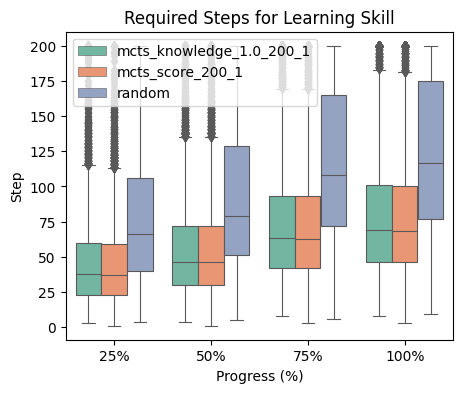

In [232]:

melted_df = original_df.copy()
#
# melted_df.rename(columns={
#     'ReachedKnowledgeStep':'100',
#     'Q1ReachedKnowledgeStep':'25',
#     'Q2ReachedKnowledgeStep':'50',
#     'Q3ReachedKnowledgeStep':'75'
# }, inplace=True)

_columns = [
'25%', '50%', '75%', '100%',
# Matched_HorizontalPiece', 'Matched_VerticalPiece', 'Matched_CrossPiece', 'Matched_RocketPiece', 'Matched_BombPiece', 'Matched_RainbowPiece'
]

# print(player_df.keys())
sns.set_palette('Set2')
# melted_df = melted_df.groupby(['method', 'objective', 'playerDepth', 'simulation']).sample(n=400, random_state=1, replace=True)
melted_df['concat_method'] = melted_df.agg(lambda x: get_legend_name(x), axis=1)
melted_df = pd.melt(melted_df, id_vars=['EpisodeCount', 'objective', 'concat_method', 'simulation', 'player'],
                    value_vars=[*_columns], ignore_index=False)
# pprint(set(melted_df['concat_method']))
_methods = [
    'mcts_kp_-_200_1',
    'mcts_knowledge_1.0_200_1',
    'mcts_score_200_1',
    'random'
]
melted_df = melted_df[melted_df['concat_method'].isin(_methods)]

plt.figure(figsize=(5, 4))
plt.clf()
ax = sns.boxplot(x="variable", y="value", hue="concat_method", data=melted_df, dodge=True, linewidth=0.8)

plt.legend(loc='upper left')
ax.set_title(f'Required Steps for Learning Skill')
ax.set_xlabel('Progress (%)')
ax.set_ylabel('Step')
# plt.savefig(f'./figures/learning_steps_p{player_no}', dpi=300)
plt.show()